In [12]:
import torch
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('examples'), '..')))

from tedeous.data import Domain, Conditions, Equation
from tedeous.model import Model
from tedeous.models import mat_model, Fourier_embedding
from tedeous.callbacks import plot, early_stopping, adaptive_lambda
from tedeous.optimizers.optimizer import Optimizer
from tedeous.device import solver_device
from tedeous.eval import integration

In [13]:
solver_device('cuda')

a = 4

def u(x):
  return torch.sin(torch.pi * a * x)

def u_x(x):
   return (torch.pi * a) * torch.cos(torch.pi * a * x)

def u_xx(x):
  return -(torch.pi * a) ** 2 * torch.sin(torch.pi * a * x)

def u_net(net, x):
    net = net.to('cpu')
    x = x.to('cpu')
    return net(x).detach()

def u_net_x(net, x):
    x = x.to('cpu')
    net = net.to('cpu')
    x.requires_grad_()
    u = net(x)
    u_x = torch.autograd.grad(sum(u), x)[0]
    return u_x.detach()

def u_net_xx(net, x):
    x = x.to('cpu')
    net = net.to('cpu')
    x.requires_grad_()
    u = net(x)
    u_x = torch.autograd.grad(sum(u), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(sum(u_x), x)[0]
    return u_xx.detach()

def c2_norm(net, x):
    norms = [(u, u_net), (u_x, u_net_x), (u_xx, u_net_xx)]
    norm = 0
    for exact, predict in norms:
        norm += torch.max(abs(exact(x).cpu().reshape(-1) - predict(net, x).cpu().reshape(-1)))
    return norm.detach().cpu().numpy()

def l2_norm(net, x):
    x = x.to('cpu')
    net = net.to('cpu')
    predict = net(x).detach().cpu().reshape(-1)
    exact = u(x).detach().cpu().reshape(-1)
    l2_norm = torch.sqrt(sum((predict-exact)**2))
    return l2_norm.detach().cpu().numpy()

def l2_norm_mat(net, x):
    x = x.to('cpu')
    net = net.to('cpu')
    predict = net.detach().cpu().reshape(-1)
    exact = u(x).detach().cpu().reshape(-1)
    l2_norm = torch.sqrt(sum((predict-exact)**2))
    return l2_norm.detach().cpu().numpy()

def experiment(N):
    exp_dict_list = []

    x0 = 0
    xmax = 1

    domain = Domain()

    domain.variable('x', [x0, xmax], N, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': x0}, value=u)
    boundaries.dirichlet({'x': xmax}, value=u)

    grid = domain.variable_dict['x'].reshape(-1,1)

    # equation: d2u/dx2 = -16*pi^2*sin(4*pi*x)

    equation = Equation()

    poisson = {
        '-d2u/dx2':
            {
            'coeff': -1,
            'term': [0, 0],
            'pow': 1,
            },

        'f(x)':
            {
            'coeff': u_xx(grid),
            'term': [None],
            'pow': 0,
            }
    }

    equation.add(poisson)

    net = torch.nn.Sequential(
            torch.nn.Linear(1, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 1)
        )

    model = Model(net, domain, equation, boundaries)

    model.compile('autograd', lambda_operator=1, lambda_bound=1)
    
    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6)

    optimizer = Optimizer('Adam', {'lr': 1e-4})

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_es])

    l2_loss = model.solution_cls.evaluate()[0].detach().cpu().numpy()

    lu_f = model.solution_cls.operator.operator_compute()

    lu_f, _ = integration(lu_f, grid)

    lu = u_net_xx(net, grid)

    lu, _ = integration(lu, grid)

    exp_dict_list.append({'grid_res': N,
                          'l2_loss': l2_loss,
                          "lu_f": lu_f.item(),
                          "lu": lu.item(),
                          'l2_norm': l2_norm(net, grid),
                          'c2_norm': c2_norm(net, grid),
                          'type':'Poisson'})

    print('grid_res=', N)
    print('c2_norm = ', c2_norm(net, grid))
    print('l2_norm = ', l2_norm(net, grid))
    print('lu_f = ', lu_f.item())
    print('lu = ', lu.item())

    plt.plot(grid.detach().cpu().numpy(), u(grid).detach().cpu().numpy(), label='Exact')
    plt.plot(grid.detach().cpu().numpy(), net(grid.cpu()).detach().cpu().numpy(), '--', label='Predicted')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper right')
    plt.show()

    return exp_dict_list

def experiment_PSO(N):
    exp_dict_list = []

    x0 = 0
    xmax = 1

    domain = Domain()

    domain.variable('x', [x0, xmax], N, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': x0}, value=u)
    boundaries.dirichlet({'x': xmax}, value=u)

    grid = domain.variable_dict['x'].reshape(-1,1)

    # equation: d2u/dx2 = -16*pi^2*sin(4*pi*x)

    equation = Equation()

    poisson = {
        '-d2u/dx2':
            {
            'coeff': -1,
            'term': [0, 0],
            'pow': 1,
            },

        'f(x)':
            {
            'coeff': u_xx(grid),
            'term': [None],
            'pow': 0,
            }
    }

    equation.add(poisson)

    net = torch.nn.Sequential(
            torch.nn.Linear(1, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 1)
        )

    model = Model(net, domain, equation, boundaries)

    model.compile('autograd', lambda_operator=1, lambda_bound=1)
    
    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6)

    optimizer = Optimizer('Adam', {'lr': 1e-4})

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_es])

    l2_pinn = l2_norm(net, grid)
    print('l2_norm = ', l2_pinn)
    net = net.to('cuda')

    ########

    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6, info_string_every=1000)

    optimizer = Optimizer('PSO', {'pop_size': 50, #30
                                  'b': 0.4, #0.5
                                  'c2': 0.5, #0.05
                                  'c1': 0.5, 
                                  'variance': 5e-2,
                                  'lr': 1e-4})

    model.train(optimizer, 2e4, save_model=False, callbacks=[cb_es])


    l2_loss = model.solution_cls.evaluate()[0].detach().cpu().numpy()

    lu_f = model.solution_cls.operator.operator_compute()

    lu_f, _ = integration(lu_f, grid)

    lu = u_net_xx(net, grid)

    lu, _ = integration(lu, grid)

    exp_dict_list.append({'grid_res': N,
                          'l2_loss': l2_loss,
                          'l2_PSO': l2_norm(net, grid),
                          'l2_pinn': l2_pinn,
                          "lu_f": lu_f.item(),
                          "lu": lu.item(),
                          'l2_norm': l2_norm(net, grid),
                          'c2_norm': c2_norm(net, grid),
                          'type':'Poisson_PSO'})

    print('grid_res=', N)
    print('c2_norm = ', c2_norm(net, grid))
    print('l2_norm = ', l2_norm(net, grid))
    print('lu_f = ', lu_f.item())
    print('lu = ', lu.item())

    plt.plot(grid.detach().cpu().numpy(), u(grid).detach().cpu().numpy(), label='Exact')
    plt.plot(grid.detach().cpu().numpy(), net(grid.cpu()).detach().cpu().numpy(), '--', label='Predicted')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper right')
    plt.show()

    return exp_dict_list

def experiment_mat(N):
    solver_device('cuda')

    exp_dict_list = []

    x0 = -1
    xmax = 1

    domain = Domain()

    domain.variable('x', [x0, xmax], N, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': x0}, value=u)
    boundaries.dirichlet({'x': xmax}, value=u)

    grid = domain.variable_dict['x']
    # equation: d2u/dx2 = -16*pi^2*sin(4*pi*x)

    equation = Equation()

    poisson = {
        '-d2u/dx2':
            {
            'coeff': -1,
            'term': [0, 0],
            'pow': 1,
            },

        'f(x)':
            {
            'coeff': u_xx(grid),
            'term': [None],
            'pow': 0,
            }
    }

    equation.add(poisson)

    net = torch.nn.Sequential(
            torch.nn.Linear(1, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 1)
        )

    model = Model(net, domain, equation, boundaries)

    model.compile('autograd', lambda_operator=1, lambda_bound=1)

    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6)

    optimizer = Optimizer('Adam', {'lr': 1e-4})

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_es])

    grid = torch.linspace(-1, 1, N+1).reshape(-1,1)

    l2_pinn = l2_norm(net, grid)
    print('l2_norm = ', l2_pinn)
    net = net.to('cuda')


    ########
    solver_device('cpu')

    net = net(grid).reshape(1, N+1).detach().cpu()

    domain = Domain()

    domain.variable('x', [x0, xmax], N, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': x0}, value=u)
    boundaries.dirichlet({'x': xmax}, value=u)

    grid = domain.variable_dict['x']
    # equation: d2u/dx2 = -16*pi^2*sin(4*pi*x)

    equation = Equation()

    poisson = {
        '-d2u/dx2':
            {
            'coeff': -1,
            'term': [0, 0],
            'pow': 1,
            },

        'f(x)':
            {
            'coeff': u_xx(grid),
            'term': [None],
            'pow': 0,
            }
    }

    equation.add(poisson)

    model = Model(net, domain, equation, boundaries)

    model.compile('mat', lambda_operator=1, lambda_bound=1, derivative_points=3)

    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6)

    optimizer = Optimizer('LBFGS', {'lr': 1e-2})

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_es])

    l2_loss = model.solution_cls.evaluate()[0].detach().cpu().numpy()

    grid = domain.build('mat')

    exp_dict_list.append({'grid_res': N, 'l2_loss': l2_loss, 'l2_mat': l2_norm_mat(net, grid), 'l2_pinn': l2_pinn, 'type':'Poisson_mat'})

    print('grid_res=', N)
    print('l2_norm = ', l2_norm_mat(net, grid))

    plt.plot(grid.detach().cpu().numpy().reshape(-1), u(grid).detach().cpu().numpy().reshape(-1), label='Exact')
    plt.plot(grid.detach().cpu().numpy().reshape(-1), net.detach().cpu().numpy().reshape(-1), '--', label='Predicted')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper right')
    plt.show()

    return exp_dict_list

def experiment_neur(N):
    exp_dict_list = []

    x0 = -1
    xmax = 1

    domain = Domain()

    domain.variable('x', [x0, xmax], 300, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': x0}, value=u)
    boundaries.dirichlet({'x': xmax}, value=u)

    grid = domain.variable_dict['x'].reshape(-1,1)

    # equation: d2u/dx2 = -16*pi^2*sin(4*pi*x)

    equation = Equation()

    poisson = {
        '-d2u/dx2':
            {
            'coeff': -1,
            'term': [0, 0],
            'pow': 1,
            },

        'f(x)':
            {
            'coeff': u_xx(grid),
            'term': [None],
            'pow': 0,
            }
    }

    equation.add(poisson)

    net = torch.nn.Sequential(
            torch.nn.Linear(1, N),
            torch.nn.Tanh(),
            torch.nn.Linear(N, N),
            torch.nn.Tanh(),
            torch.nn.Linear(N, N),
            torch.nn.Tanh(),
            torch.nn.Linear(N, 1)
        )

    model = Model(net, domain, equation, boundaries)

    model.compile('autograd', lambda_operator=1, lambda_bound=1)

    img_dir = os.path.join(os.path.dirname('examples'), 'poisson_img')
    
    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6)

    cb_plots = plot.Plots(save_every=None, print_every=None, img_dir=img_dir)

    optimizer = Optimizer('Adam', {'lr': 1e-4}, gamma=0.9, decay_every=1000)

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_plots, cb_es])

    l2_loss = model.solution_cls.evaluate()[0].detach().cpu().numpy()

    grid_error = torch.linspace(-1, 1, 10001).reshape(-1,1)

    exp_dict_list.append({'NN_res': N, 'l2_loss': l2_loss, 'l2_norm': l2_norm(net, grid_error), 'c2_norm': c2_norm(net, grid_error), 'type':'Poisson'})

    print('grid_res=', N)
    print('c2_norm = ', c2_norm(net, grid_error))
    print('l2_norm = ', l2_norm(net, grid_error))

    plt.plot(grid.detach().cpu().numpy(), u(grid).detach().cpu().numpy(), label='Exact')
    plt.plot(grid.detach().cpu().numpy(), net(grid.cpu()).detach().cpu().numpy(), '--', label='Predicted')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper right')
    plt.show()

    return exp_dict_list

def experiment_lam(N):
    exp_dict_list = []

    x0 = 0
    xmax = 1

    domain = Domain()

    domain.variable('x', [x0, xmax], N, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': x0}, value=u)
    boundaries.dirichlet({'x': xmax}, value=u)

    grid = domain.variable_dict['x'].reshape(-1,1)

    # equation: d2u/dx2 = -16*pi^2*sin(4*pi*x)

    equation = Equation()

    poisson = {
        '-d2u/dx2':
            {
            'coeff': -1,
            'term': [0, 0],
            'pow': 1,
            },

        'f(x)':
            {
            'coeff': u_xx(grid),
            'term': [None],
            'pow': 0,
            }
    }

    equation.add(poisson)

    net = torch.nn.Sequential(
            torch.nn.Linear(1, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 1)
        )

    model = Model(net, domain, equation, boundaries)

    model.compile('autograd', lambda_operator=1, lambda_bound=1)
    
    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6, normalized_loss=True)
    cb_lam = adaptive_lambda.AdaptiveLambda()

    optimizer = Optimizer('Adam', {'lr': 1e-4})

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_es, cb_lam])

    l2_loss = model.solution_cls.evaluate()[0].detach().cpu().numpy()

    lu_f = model.solution_cls.operator.operator_compute()

    lu_f, _ = integration(lu_f, grid)

    lu = u_net_xx(net, grid)

    lu, _ = integration(lu, grid)

    exp_dict_list.append({'grid_res': N,
                          'l2_loss': l2_loss,
                          "lu_f": lu_f.item(),
                          "lu": lu.item(),
                          'l2_norm': l2_norm(net, grid),
                          'c2_norm': c2_norm(net, grid),
                          'type':'Poisson'})

    print('grid_res=', N)
    print('c2_norm = ', c2_norm(net, grid))
    print('l2_norm = ', l2_norm(net, grid))
    print('lu_f = ', lu_f.item())
    print('lu = ', lu.item())

    plt.plot(grid.detach().cpu().numpy(), u(grid).detach().cpu().numpy(), label='Exact')
    plt.plot(grid.detach().cpu().numpy(), net(grid.cpu()).detach().cpu().numpy(), '--', label='Predicted')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper right')
    plt.show()

    return exp_dict_list

    return exp_dict_list

def experiment_fourier(N):
    exp_dict_list = []

    x0 = -1
    xmax = 1

    domain = Domain()

    domain.variable('x', [x0, xmax], N, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': x0}, value=u)
    boundaries.dirichlet({'x': xmax}, value=u)

    grid = domain.variable_dict['x'].reshape(-1,1)

    # equation: d2u/dx2 = -16*pi^2*sin(4*pi*x)

    equation = Equation()

    poisson = {
        '-d2u/dx2':
            {
            'coeff': -1,
            'term': [0, 0],
            'pow': 1,
            },

        'f(x)':
            {
            'coeff': u_xx(grid),
            'term': [None],
            'pow': 0,
            }
    }

    equation.add(poisson)

    FFL = Fourier_embedding(L=[2], M=[1])

    out = FFL.out_features

    net = torch.nn.Sequential(
            FFL,
            torch.nn.Linear(out, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 1)
        )

    model = Model(net, domain, equation, boundaries)

    model.compile('autograd', lambda_operator=1, lambda_bound=1)
    
    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6)

    optimizer = Optimizer('Adam', {'lr': 1e-3}, gamma=0.9, decay_every=1000)

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_es])

    l2_loss = model.solution_cls.evaluate()[0].detach().cpu().numpy()

    grid_error = torch.linspace(-1, 1, 10001).reshape(-1,1)

    exp_dict_list.append({'grid_res': N, 'l2_loss': l2_loss, 'l2_norm': l2_norm(net, grid_error), 'type':'Poisson'})

    print('grid_res=', N)
    # print('c2_norm = ', c2_norm(net, grid_error))
    print('l2_norm = ', l2_norm(net, grid_error))

    plt.plot(grid.detach().cpu().numpy(), u(grid).detach().cpu().numpy(), label='Exact')
    plt.plot(grid.detach().cpu().numpy(), net(grid).detach().cpu().numpy(), '--', label='Predicted')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper right')
    plt.show()

    return exp_dict_list


CUDA is available and used.


In [14]:

# Создайте список для каждой части
part1 = np.arange(2, 10, 3)
part2 = np.arange(10, 100, 30)
part3 = np.arange(100, 1000, 300)
part4 = np.arange(1000, 11000, 3000)
part5 = np.array([100000])

neurons = np.array([2, 8, 16, 32, 64, 128, 216, 512])

grid_n = np.concatenate([part1, part2, part3, part4])

[2024-03-15 13:31:05.261597] initial (min) loss is 0.01157407183200121
lambda_eq_0: 3.2725796699523926
lambda_dirichlet: 1.4400285482406616
lambda_eq_0: 4.318366050720215
lambda_dirichlet: 1.301353096961975
lambda_eq_0: 2.8444604873657227
lambda_dirichlet: 1.5421639680862427
lambda_eq_0: 3.844231128692627
lambda_dirichlet: 1.3515888452529907
lambda_eq_0: 1.842339277267456
lambda_dirichlet: 2.1871700286865234
lambda_eq_0: 1.3699156045913696
lambda_dirichlet: 3.703319549560547
lambda_eq_0: 2.5501840114593506
lambda_dirichlet: 1.6450847387313843
lambda_eq_0: 4.094034671783447
lambda_dirichlet: 1.3232026100158691
lambda_eq_0: 3.83566951751709
lambda_dirichlet: 1.3526504039764404
lambda_eq_0: 4.098494052886963
lambda_dirichlet: 1.322737455368042
lambda_eq_0: 3.7468886375427246
lambda_dirichlet: 1.3640482425689697
lambda_eq_0: 3.9932150840759277
lambda_dirichlet: 1.334088921546936
lambda_eq_0: 3.7581069469451904
lambda_dirichlet: 1.3625675439834595
lambda_eq_0: 3.8899447917938232
lambda_diri

c:\ITMO\solver_aminevdam\torch_DE_solver\tedeous\callbacks\adaptive_lambda.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  lambdas.append(sum(ST) / sum(ST[pointer:pointer + value]))


lambda_eq_0: 1.0
lambda_dirichlet: inf
lambda_eq_0: nan
lambda_dirichlet: nan
lambda_eq_0: nan
lambda_dirichlet: nan
lambda_eq_0: nan
lambda_dirichlet: nan
lambda_eq_0: nan
lambda_dirichlet: nan
lambda_eq_0: nan
lambda_dirichlet: nan
lambda_eq_0: nan
lambda_dirichlet: nan
lambda_eq_0: nan
lambda_dirichlet: nan
lambda_eq_0: nan
lambda_dirichlet: nan
lambda_eq_0: nan
lambda_dirichlet: nan
lambda_eq_0: nan
lambda_dirichlet: nan
lambda_eq_0: nan
lambda_dirichlet: nan
lambda_eq_0: nan
lambda_dirichlet: nan
lambda_eq_0: nan
lambda_dirichlet: nan
lambda_eq_0: nan
lambda_dirichlet: nan
lambda_eq_0: nan
lambda_dirichlet: nan
lambda_eq_0: nan
lambda_dirichlet: nan
lambda_eq_0: nan
lambda_dirichlet: nan
lambda_eq_0: nan
lambda_dirichlet: nan
lambda_eq_0: nan
lambda_dirichlet: nan
lambda_eq_0: nan
lambda_dirichlet: nan
lambda_eq_0: nan
lambda_dirichlet: nan
lambda_eq_0: nan
lambda_dirichlet: nan
lambda_eq_0: nan
lambda_dirichlet: nan
lambda_eq_0: nan
lambda_dirichlet: nan
lambda_eq_0: nan
lambda_d

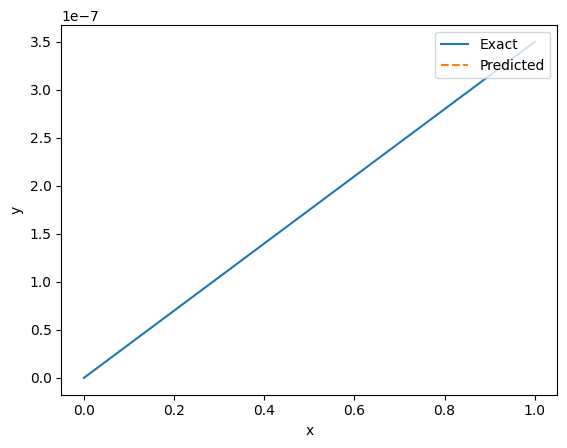

[2024-03-15 13:31:50.703042] initial (min) loss is 10390.7587890625
lambda_eq_0: 2.2366273403167725
lambda_dirichlet: 1.8086509704589844
lambda_eq_0: 2.3144359588623047
lambda_dirichlet: 1.7607825994491577
lambda_eq_0: 2.2857418060302734
lambda_dirichlet: 1.7777611017227173
lambda_eq_0: 2.3013174533843994
lambda_dirichlet: 1.7684520483016968
lambda_eq_0: 2.312516689300537
lambda_dirichlet: 1.7618951797485352
lambda_eq_0: 2.313709259033203
lambda_dirichlet: 1.761203408241272
lambda_eq_0: 2.307405948638916
lambda_dirichlet: 1.7648733854293823
lambda_eq_0: 2.2919583320617676
lambda_dirichlet: 1.7740187644958496
lambda_eq_0: 2.271369457244873
lambda_dirichlet: 1.7865533828735352
lambda_eq_0: 2.299570083618164
lambda_dirichlet: 1.7694852352142334
lambda_eq_0: 2.338533878326416
lambda_dirichlet: 1.7470860481262207
lambda_eq_0: 2.376699686050415
lambda_dirichlet: 1.7263747453689575
lambda_eq_0: 2.4008994102478027
lambda_dirichlet: 1.713827133178711
lambda_eq_0: 2.3941290378570557
lambda_diric

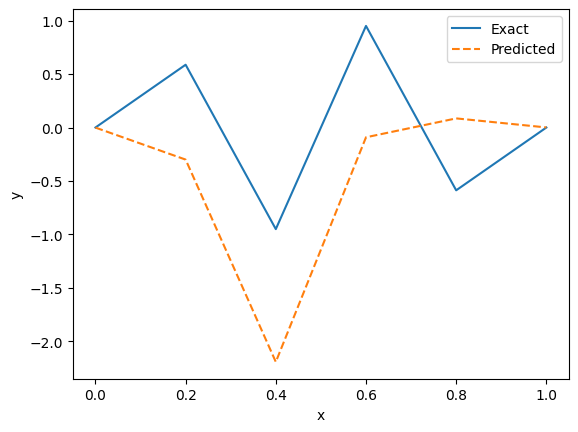

[2024-03-15 13:34:06.022173] initial (min) loss is 11082.3935546875
lambda_eq_0: 1.7736952304840088
lambda_dirichlet: 2.2924985885620117
lambda_eq_0: 1.8257933855056763
lambda_dirichlet: 2.210956573486328
lambda_eq_0: 1.8121469020843506
lambda_dirichlet: 2.231304407119751
lambda_eq_0: 1.8223503828048706
lambda_dirichlet: 2.216026782989502
lambda_eq_0: 1.830543041229248
lambda_dirichlet: 2.204031467437744
lambda_eq_0: 1.8321458101272583
lambda_dirichlet: 2.2017123699188232
lambda_eq_0: 1.825323462486267
lambda_dirichlet: 2.21164608001709
lambda_eq_0: 1.8092000484466553
lambda_dirichlet: 2.235788345336914
lambda_eq_0: 1.818111777305603
lambda_dirichlet: 2.2223267555236816
lambda_eq_0: 1.8676961660385132
lambda_dirichlet: 2.152477264404297
lambda_eq_0: 1.8766292333602905
lambda_dirichlet: 2.140733003616333
lambda_eq_0: 1.8542743921279907
lambda_dirichlet: 2.170583963394165
lambda_eq_0: 1.824920654296875
lambda_dirichlet: 2.21223783493042
lambda_eq_0: 1.7884924411773682
lambda_dirichlet: 2

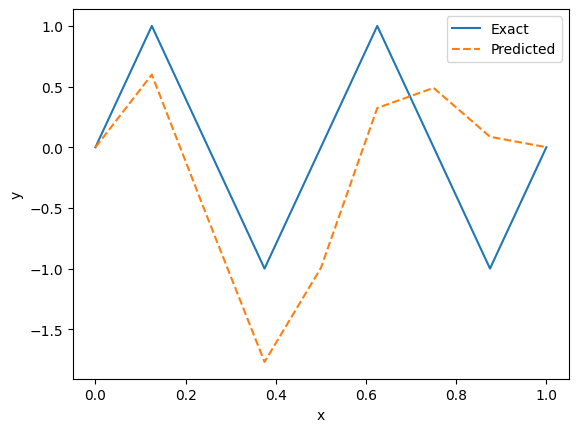

[2024-03-15 13:36:14.725401] initial (min) loss is 11334.17578125
lambda_eq_0: 1.622417688369751
lambda_dirichlet: 2.606637954711914
lambda_eq_0: 1.6691961288452148
lambda_dirichlet: 2.4943301677703857
lambda_eq_0: 1.6622599363327026
lambda_dirichlet: 2.509981155395508
lambda_eq_0: 1.667907476425171
lambda_dirichlet: 2.497213363647461
lambda_eq_0: 1.6712713241577148
lambda_dirichlet: 2.489710569381714
lambda_eq_0: 1.6657308340072632
lambda_dirichlet: 2.502108573913574
lambda_eq_0: 1.6467714309692383
lambda_dirichlet: 2.5461411476135254
lambda_eq_0: 1.6739959716796875
lambda_dirichlet: 2.4836883544921875
lambda_eq_0: 1.708082914352417
lambda_dirichlet: 2.412264108657837
lambda_eq_0: 1.704232931137085
lambda_dirichlet: 2.419984817504883
lambda_eq_0: 1.6670210361480713
lambda_dirichlet: 2.4992029666900635
lambda_eq_0: 1.6231013536453247
lambda_dirichlet: 2.604875326156616
lambda_eq_0: 1.5669591426849365
lambda_dirichlet: 2.7637956142425537
lambda_eq_0: 1.5185089111328125
lambda_dirichlet:

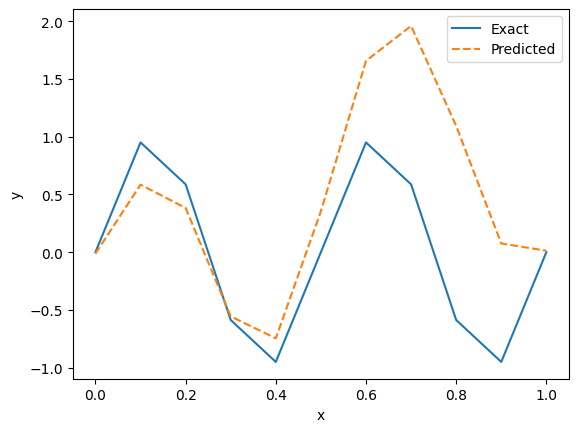

[2024-03-15 13:38:00.750849] initial (min) loss is 12164.6923828125
lambda_eq_0: 1.157887578010559
lambda_dirichlet: 7.333619594573975
lambda_eq_0: 1.1851751804351807
lambda_dirichlet: 6.4002909660339355
lambda_eq_0: 1.1907347440719604
lambda_dirichlet: 6.242884159088135
lambda_eq_0: 1.18964684009552
lambda_dirichlet: 6.272957801818848
lambda_eq_0: 1.1600120067596436
lambda_dirichlet: 7.249533176422119
lambda_eq_0: 1.1343119144439697
lambda_dirichlet: 8.445356369018555
lambda_eq_0: 1.1320903301239014
lambda_dirichlet: 8.570577621459961
lambda_eq_0: 1.1426856517791748
lambda_dirichlet: 8.008411407470703
lambda_eq_0: 1.1534746885299683
lambda_dirichlet: 7.515732765197754
lambda_eq_0: 1.1845989227294922
lambda_dirichlet: 6.417149066925049
lambda_eq_0: 1.158517599105835
lambda_dirichlet: 7.308446884155273
lambda_eq_0: 1.1364662647247314
lambda_dirichlet: 8.327817916870117
lambda_eq_0: 1.1406363248825073
lambda_dirichlet: 8.110538482666016
lambda_eq_0: 1.1460063457489014
lambda_dirichlet: 7

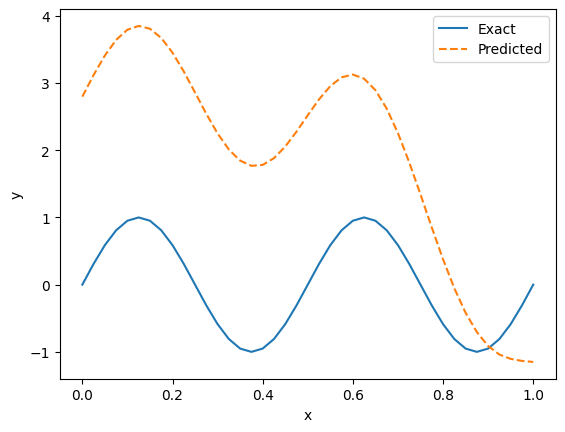

[2024-03-15 13:39:49.857313] initial (min) loss is 12292.6806640625
lambda_eq_0: 1.1097019910812378
lambda_dirichlet: 10.115602493286133
lambda_eq_0: 1.105762004852295
lambda_dirichlet: 10.455187797546387
lambda_eq_0: 1.0702557563781738
lambda_dirichlet: 15.233708381652832
lambda_eq_0: 1.0971757173538208
lambda_dirichlet: 11.290630340576172
lambda_eq_0: 1.087282419204712
lambda_dirichlet: 12.457061767578125
lambda_eq_0: 1.0728892087936401
lambda_dirichlet: 14.71944522857666
lambda_eq_0: 1.082201361656189
lambda_dirichlet: 13.165243148803711
lambda_eq_0: 1.0876858234405518
lambda_dirichlet: 12.404351234436035
lambda_eq_0: 1.0888962745666504
lambda_dirichlet: 12.249063491821289
lambda_eq_0: 1.0839793682098389
lambda_dirichlet: 12.907691955566406
lambda_eq_0: 1.0822229385375977
lambda_dirichlet: 13.16204833984375
lambda_eq_0: 1.082254409790039
lambda_dirichlet: 13.157398223876953
lambda_eq_0: 1.1080706119537354
lambda_dirichlet: 10.253210067749023
lambda_eq_0: 1.084751009941101
lambda_dir

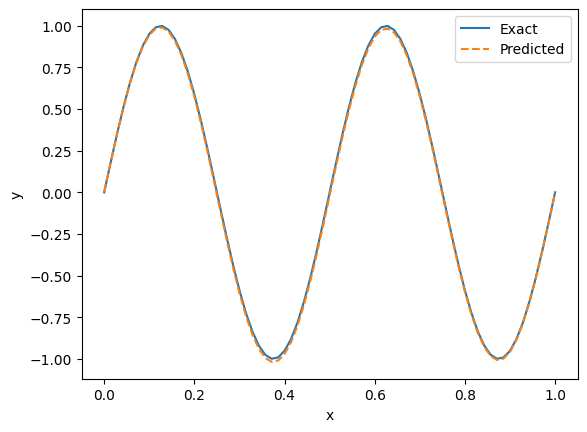

[2024-03-15 13:42:40.164963] initial (min) loss is 12344.7470703125
lambda_eq_0: 1.092938780784607
lambda_dirichlet: 11.759767532348633
lambda_eq_0: 1.1437008380889893
lambda_dirichlet: 7.95890474319458
lambda_eq_0: 1.0532132387161255
lambda_dirichlet: 19.792322158813477
lambda_eq_0: 1.0610547065734863
lambda_dirichlet: 17.37874984741211
lambda_eq_0: 1.0529166460037231
lambda_dirichlet: 19.897647857666016
lambda_eq_0: 1.0656123161315918
lambda_dirichlet: 16.241029739379883
lambda_eq_0: 1.0613369941711426
lambda_dirichlet: 17.303390502929688
lambda_eq_0: 1.054914951324463
lambda_dirichlet: 19.209993362426758
lambda_eq_0: 1.0577938556671143
lambda_dirichlet: 18.302879333496094
lambda_eq_0: 1.0587544441223145
lambda_dirichlet: 18.01999282836914
lambda_eq_0: 1.0565135478973389
lambda_dirichlet: 18.694889068603516
lambda_eq_0: 1.0575913190841675
lambda_dirichlet: 18.363731384277344
lambda_eq_0: 1.059275507926941
lambda_dirichlet: 17.87036895751953
lambda_eq_0: 1.0599372386932373
lambda_diri

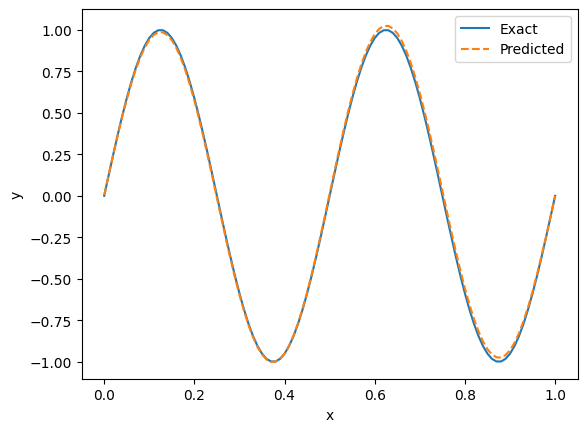

[2024-03-15 13:46:44.321974] initial (min) loss is 12434.9736328125
lambda_eq_0: 1.0277644395828247
lambda_dirichlet: 37.017295837402344
lambda_eq_0: 1.0133826732635498
lambda_dirichlet: 75.72370147705078
lambda_eq_0: 1.0140286684036255
lambda_dirichlet: 72.28258514404297
lambda_eq_0: 1.0263978242874146
lambda_dirichlet: 38.88190460205078
lambda_eq_0: 1.0078392028808594
lambda_dirichlet: 128.56423950195312
lambda_eq_0: 1.0059077739715576
lambda_dirichlet: 170.26992797851562
[2024-03-15 13:49:20.818389] No improvement in 1000 steps
[2024-03-15 13:49:20.818389] Step = 5040 loss = 498.485504 normalized loss line= -0.000028x+1.004201. There was 1 stop dings already.
lambda_eq_0: 1.0039680004119873
lambda_dirichlet: 253.01947021484375
[2024-03-15 13:49:48.145791] No improvement in 1000 steps
[2024-03-15 13:49:48.145791] Step = 6040 loss = 494.439697 normalized loss line= -0.000028x+1.005151. There was 2 stop dings already.
lambda_eq_0: 1.003185749053955
lambda_dirichlet: 314.89666748046875


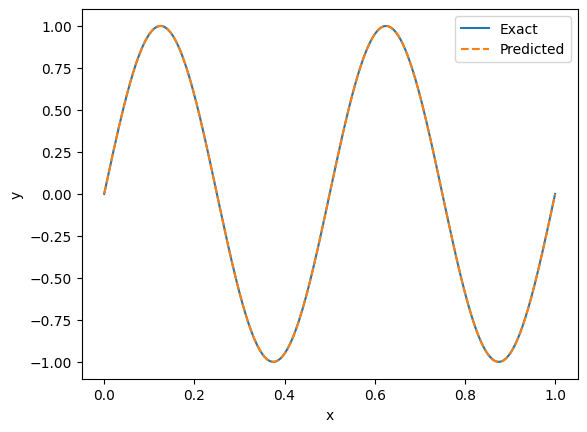

[2024-03-15 13:54:36.846768] initial (min) loss is 12449.9248046875
lambda_eq_0: 1.0068354606628418
lambda_dirichlet: 147.29515075683594
lambda_eq_0: 1.0100321769714355
lambda_dirichlet: 100.67921447753906
lambda_eq_0: 1.003920316696167
lambda_dirichlet: 256.07989501953125
[2024-03-15 13:58:19.546233] No improvement in 1000 steps
[2024-03-15 13:58:19.547233] Step = 5224 loss = 503.381073 normalized loss line= -0.000023x+1.002991. There was 1 stop dings already.
lambda_eq_0: 1.0025966167449951
lambda_dirichlet: 386.1155090332031
lambda_eq_0: 1.006966471672058
lambda_dirichlet: 144.5453338623047
lambda_eq_0: 1.0054370164871216
lambda_dirichlet: 184.92340087890625
lambda_eq_0: 1.003580927848816
lambda_dirichlet: 280.2551574707031
lambda_eq_0: 1.0018218755722046
lambda_dirichlet: 549.8997802734375
lambda_eq_0: 1.0000675916671753
lambda_dirichlet: 14786.8603515625
lambda_eq_0: 1.0
lambda_dirichlet: 1190988416.0
[2024-03-15 14:06:41.990354] No improvement in 1000 steps
[2024-03-15 14:06:41.9

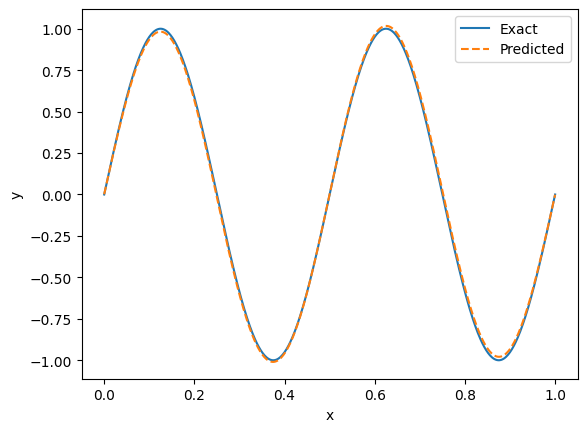

[2024-03-15 14:09:07.078815] initial (min) loss is 12458.2001953125
lambda_eq_0: 1.0046360492706299
lambda_dirichlet: 216.6988067626953
lambda_eq_0: 1.007269263267517
lambda_dirichlet: 138.5651397705078
lambda_eq_0: 1.0027918815612793
lambda_dirichlet: 359.1867370605469
[2024-03-15 14:16:12.843584] No improvement in 1000 steps
[2024-03-15 14:16:12.843584] Step = 7024 loss = 491.014160 normalized loss line= -0.000017x+1.002265. There was 1 stop dings already.
lambda_eq_0: 1.001586675643921
lambda_dirichlet: 631.2557373046875
lambda_eq_0: 1.003783941268921
lambda_dirichlet: 265.2742614746094
lambda_eq_0: 1.0020214319229126
lambda_dirichlet: 495.6985168457031
lambda_eq_0: 1.0000327825546265
lambda_dirichlet: 30468.83203125
lambda_eq_0: 1.0
lambda_dirichlet: 36625825792.0
[2024-03-15 14:27:48.565799] No improvement in 1000 steps
[2024-03-15 14:27:48.565799] Step = 17064 loss = 4.329906 normalized loss line= -0.000059x+1.010473. There was 2 stop dings already.
[2024-03-15 14:27:55.938561] N

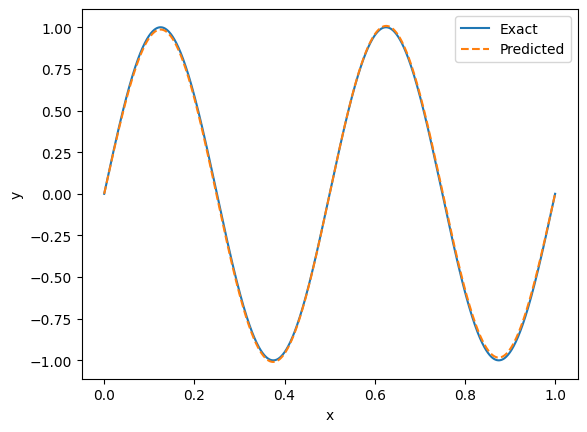

[2024-03-15 14:30:15.790988] initial (min) loss is 12464.44140625
lambda_eq_0: 1.0007696151733398
lambda_dirichlet: 1300.2706298828125
[2024-03-15 15:04:21.830626] No improvement in 1000 steps
[2024-03-15 15:04:21.830626] Step = 9008 loss = 1611.189819 normalized loss line= -0.000279x+1.031377. There was 1 stop dings already.
[2024-03-15 15:04:28.951148] No improvement in 1000 steps
[2024-03-15 15:04:28.951148] Step = 10008 loss = 898.583984 normalized loss line= -0.000515x+1.058039. There was 2 stop dings already.
[2024-03-15 15:04:36.057923] No improvement in 1000 steps
[2024-03-15 15:04:36.057923] Step = 11008 loss = 738.853516 normalized loss line= -0.000130x+1.015001. There was 3 stop dings already.
[2024-03-15 15:04:43.173103] No improvement in 1000 steps
[2024-03-15 15:04:43.174104] Step = 12008 loss = 435.156738 normalized loss line= -0.001272x+1.149878. There was 4 stop dings already.
lambda_eq_0: 1.0000457763671875
lambda_dirichlet: 21856.33203125
lambda_eq_0: 1.0002455711364

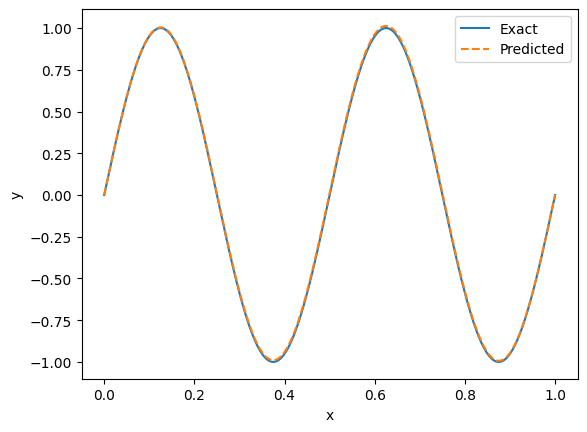

[2024-03-15 17:20:19.360965] initial (min) loss is 12465.7373046875
lambda_eq_0: 1.0003232955932617
lambda_dirichlet: 3093.90234375
[2024-03-15 19:04:45.997119] No improvement in 1000 steps
[2024-03-15 19:04:45.997119] Step = 15000 loss = 1.376676 normalized loss line= -0.001446x+1.151591. There was 1 stop dings already.
lambda_eq_0: 1.0000008344650269
lambda_dirichlet: 1243191.625
[2024-03-15 20:49:31.162687] No improvement in 1000 steps
[2024-03-15 20:49:31.162687] Step = 29016 loss = 0.005816 normalized loss line= -0.002227x+1.262518. There was 2 stop dings already.
[2024-03-15 20:49:37.809754] No improvement in 1000 steps
[2024-03-15 20:49:37.810753] Step = 30016 loss = 0.001834 normalized loss line= -0.000704x+1.085921. There was 3 stop dings already.
[2024-03-15 20:49:44.474544] No improvement in 1000 steps
[2024-03-15 20:49:44.474544] Step = 31016 loss = 0.001156 normalized loss line= -0.000232x+1.028339. There was 4 stop dings already.
[2024-03-15 20:49:51.132095] No improvemen

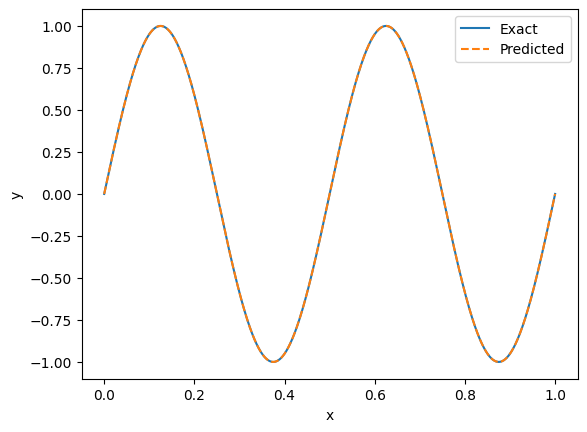

[2024-03-15 20:49:59.531349] initial (min) loss is 12467.1884765625
lambda_eq_0: 1.000227689743042
lambda_dirichlet: 4393.54638671875
lambda_eq_0: 1.0000008344650269
lambda_dirichlet: 1180736.125
[2024-03-16 03:57:39.757759] No improvement in 1000 steps
[2024-03-16 03:57:39.757759] Step = 41002 loss = 0.003153 normalized loss line= -0.000281x+1.030021. There was 1 stop dings already.
[2024-03-16 03:57:46.478999] No improvement in 1000 steps
[2024-03-16 03:57:46.478999] Step = 42002 loss = 0.002768 normalized loss line= -0.000054x+1.005843. There was 2 stop dings already.
[2024-03-16 03:57:53.238275] No improvement in 1000 steps
[2024-03-16 03:57:53.238275] Step = 43002 loss = 0.002640 normalized loss line= -0.000036x+1.003976. There was 3 stop dings already.
[2024-03-16 03:57:59.969341] No improvement in 1000 steps
[2024-03-16 03:57:59.969341] Step = 44002 loss = 0.002559 normalized loss line= -0.000036x+1.002930. There was 4 stop dings already.
[2024-03-16 03:58:06.715698] No improvem

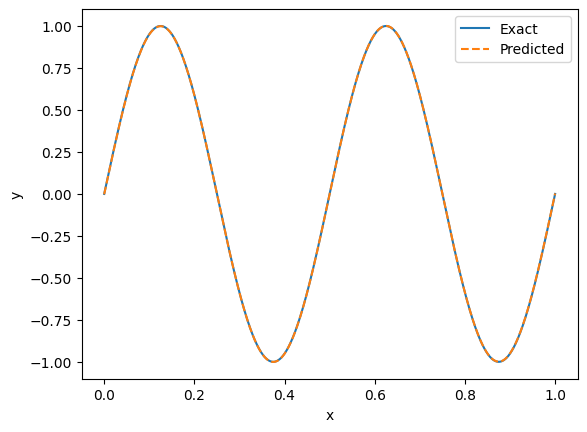

In [16]:
import pandas as pd

exp_dict_list=[]

nruns = 1

for N in grid_n:
    for _ in range(nruns):
        exp_dict_list.append(experiment_lam(N))

exp_dict_list_flatten = [item for sublist in exp_dict_list for item in sublist]
df = pd.DataFrame(exp_dict_list_flatten)
df.to_csv('error_estimation2_PINN_lam.csv')

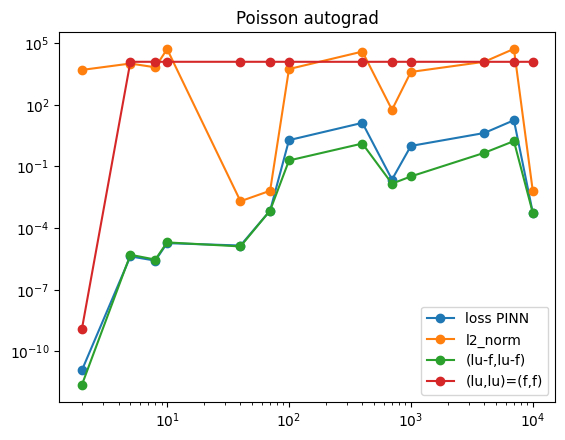

In [8]:
from ast import literal_eval

df_pinn = pd.read_csv('error_estimation2_PINN.csv')
y = []
for i in df_pinn['l2_loss']:
    y.append(literal_eval(i)[0])
# plt.plot(df['grid_res'], df_pinn['l2_norm']**2, '-*', label='l2_norm: PINN')
plt.plot(df_pinn['grid_res'], y, '-o', label='loss PINN')
plt.plot(df_pinn['grid_res'], df_pinn['l2_norm']**2, '-o', label='l2_norm')
plt.plot(df_pinn['grid_res'], df_pinn['lu_f'], '-o', label='(lu-f,lu-f)')
plt.plot(df_pinn['grid_res'], df_pinn['lu'], '-o', label='(lu,lu)=(f,f)')
plt.yscale('log')
plt.xscale('log')
plt.title('Poisson autograd')
plt.legend()

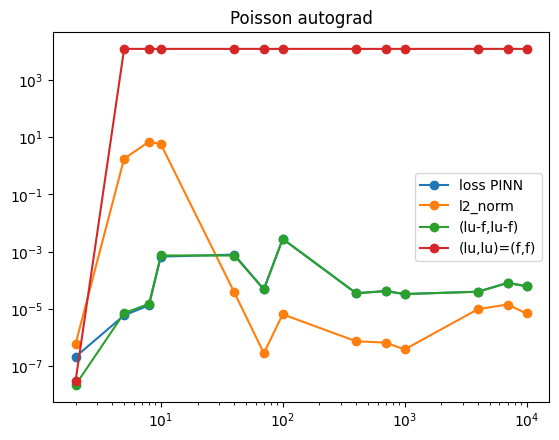

In [9]:
from ast import literal_eval

df_pinn = pd.read_csv('error_estimation2_PINN1.csv')
y = []
for i in df_pinn['l2_loss']:
    y.append(literal_eval(i)[0])
# plt.plot(df['grid_res'], df_pinn['l2_norm']**2, '-*', label='l2_norm: PINN')
plt.plot(df_pinn['grid_res'], y, '-o', label='loss PINN')
plt.plot(df_pinn['grid_res'], df_pinn['l2_norm']**2, '-o', label='l2_norm')
plt.plot(df_pinn['grid_res'], df_pinn['lu_f'], '-o', label='(lu-f,lu-f)')
plt.plot(df_pinn['grid_res'], df_pinn['lu'], '-o', label='(lu,lu)=(f,f)')
plt.yscale('log')
plt.xscale('log')
plt.title('Poisson autograd')
plt.legend()

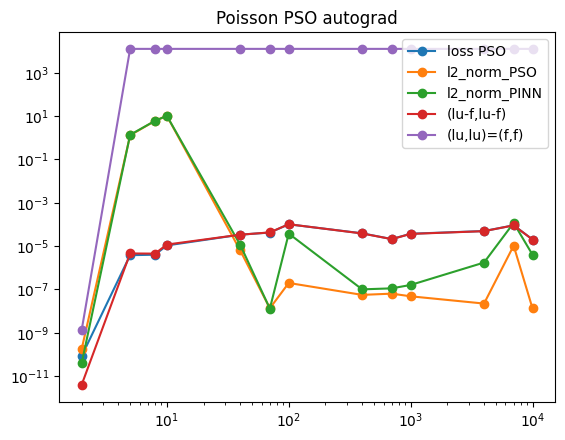

In [10]:
from ast import literal_eval

df_pinn = pd.read_csv('error_estimation2_PINN_PSO.csv')
y = []
for i in df_pinn['l2_loss']:
    y.append(literal_eval(i)[0])
# plt.plot(df['grid_res'], df_pinn['l2_norm']**2, '-*', label='l2_norm: PINN')
plt.plot(df_pinn['grid_res'], y, '-o', label='loss PSO')
plt.plot(df_pinn['grid_res'], df_pinn['l2_norm']**2, '-o', label='l2_norm_PSO')
plt.plot(df_pinn['grid_res'], df_pinn['l2_pinn']**2, '-o', label='l2_norm_PINN')
plt.plot(df_pinn['grid_res'], df_pinn['lu_f'], '-o', label='(lu-f,lu-f)')
plt.plot(df_pinn['grid_res'], df_pinn['lu'], '-o', label='(lu,lu)=(f,f)')
plt.yscale('log')
plt.xscale('log')
plt.title('Poisson PSO autograd')
plt.legend()


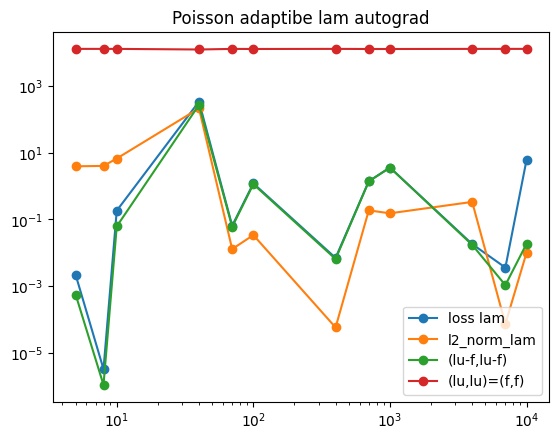

In [21]:
from ast import literal_eval

df_pinn = pd.read_csv('error_estimation2_PINN_lam.csv')
y = []
for i in df_pinn['l2_loss']:
    y.append(literal_eval(i)[0])
# plt.plot(df['grid_res'], df_pinn['l2_norm']**2, '-*', label='l2_norm: PINN')
plt.plot(df_pinn['grid_res'], y, '-o', label='loss lam')
plt.plot(df_pinn['grid_res'], df_pinn['l2_norm']**2, '-o', label='l2_norm_lam')
# plt.plot(df_pinn['grid_res'], df_pinn['l2_pinn']**2, '-o', label='l2_norm_PINN')
plt.plot(df_pinn['grid_res'], df_pinn['lu_f'], '-o', label='(lu-f,lu-f)')
plt.plot(df_pinn['grid_res'], df_pinn['lu'], '-o', label='(lu,lu)=(f,f)')
plt.yscale('log')
plt.xscale('log')
plt.title('Poisson adaptibe lam autograd')
plt.legend()

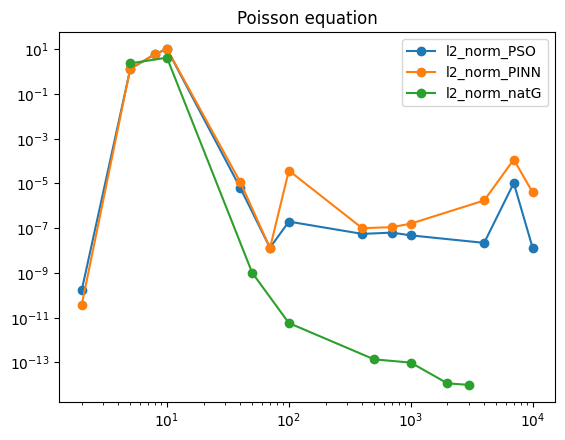

In [30]:
from ast import literal_eval

df_natG = pd.read_csv('error_estimation2_PINN_natG.csv')
y = []
for i in df_natG['l2_loss']:
    y.append(literal_eval(i)[0])

df_pinn = pd.read_csv('error_estimation2_PINN_PSO.csv')

plt.plot(df_pinn['grid_res'], df_pinn['l2_norm']**2, '-o', label='l2_norm_PSO')
plt.plot(df_pinn['grid_res'], df_pinn['l2_pinn']**2, '-o', label='l2_norm_PINN')
# plt.plot(df_natG['grid_res'], y, '-o', label='loss nat Grad')
plt.plot(df_natG['grid_res'], df_natG['l2_norm']**2, '-o', label='l2_norm_natG')

plt.yscale('log')
plt.xscale('log')
plt.title('Poisson equation')
plt.legend()
plt.show()

Уравнение Пуассона с аналитическим решением u=tanh(x)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import least_squares

def func(x, a):
    return a / (x)


ydata_pinn = df_pinn['l2_norm']
ydata_lip = df_lip['l2_norm']

plt.plot(df_pinn['grid_res'], ydata_pinn**2, '-*', label='l2_norm: PINN')
plt.plot(df_lip['grid_res'], ydata_lip**2, '-*', label='l2_norm: LIPSH')
plt.xlabel('the number of training data, $m_r$')
plt.ylabel('error')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-8, 100)
# plt.xlim(0, 1e4)

popt, pcov = curve_fit(func, df_pinn['grid_res'], ydata_pinn**2)
# def minim(a):
#     return func(xdata, a) - ydata
# result = least_squares(minim, 1)

plt.plot(df_pinn['grid_res'], func(df_pinn['grid_res'], *popt), '--', label=r"$C m_r^{-\frac{\alpha}{d}}$, C=0.75, $\alpha$=1, d=1")
plt.legend(fontsize="12")

## альфа - константа гёльедра.
## d - размерность входного пространства (R^d)
## C - подобранная константа методом curve_fit
popt

график из статьи https://arxiv.org/pdf/2004.01806.pdf

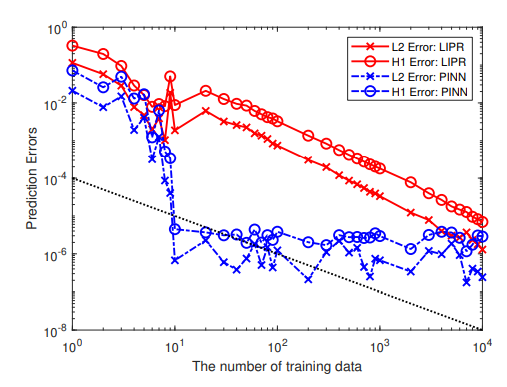

In [ ]:
df_pso = pd.read_csv('error_estimation_PINN_PSO.csv')

ydata_pso = df_pso['l2_PSO']
ydata_pinn = df_pso['l2_pinn']

plt.plot(df_pso['grid_res'], ydata_pso**2, '-*', label='l2_norm: PSO')
plt.plot(df_pso['grid_res'], ydata_pinn**2, '-o', label='l2_norm: PINN')

plt.xlabel('the number of training data, $m_r$')
plt.ylabel('error')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize="12")
# plt.ylim(1e-8, 100)

In [ ]:
df_pso = pd.read_csv('error_estimation_mat.csv')

ydata_pso = df_pso['l2_mat']
ydata_pinn = df_pso['l2_pinn']

plt.plot(df_pso['grid_res'], ydata_pso**2, '-*', label='l2_norm: mat')
plt.plot(df_pso['grid_res'], ydata_pinn**2, '-o', label='l2_norm: autograd')

plt.xlabel('the number of training data, $m_r$')
plt.ylabel('error')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize="12")
# plt.ylim(1e-8, 100)

In [ ]:
from ast import literal_eval
df = pd.read_csv('error_estimation_PINN_neurons.csv')

# ydata_pso = df_pso['l2_mat']
ydata_pinn = df['l2_norm']

# plt.plot(df_pso['grid_res'], ydata_pso**2, '-*', label='l2_norm: mat')
plt.plot(df['NN_res'], ydata_pinn**2, '-o', label='l2_norm: autograd')

plt.xlabel('the number of neurons, $N$')
plt.ylabel('error')
plt.yscale('log')
# plt.xscale('log')
plt.legend(fontsize="12")

In [ ]:
df = pd.read_csv('error_estimation_PINN_fourier.csv')
ydata_fourier = df['l2_norm']

df_pinn = pd.read_csv('error_estimation_PINN_1.csv')

plt.plot(df_pinn['grid_res'], df_pinn['l2_norm']**2, '-*', label='l2_norm: autograd')
plt.plot(df['grid_res'], ydata_fourier**2, '-o', label='l2_norm: autograd_fourier')
plt.xlabel('the number of training data, $m_r$')
plt.ylabel('error')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize="12")


In [ ]:
df = pd.read_csv('error_estimation_PINN_lam.csv')
ydata_lam = df['l2_norm']

df_pinn = pd.read_csv('error_estimation_PINN_1.csv')

plt.plot(df_pinn['grid_res'], df_pinn['l2_norm']**2, '-*', label='l2_norm: autograd')
plt.plot(df['grid_res'], ydata_lam**2, '-o', label='l2_norm: autograd_lam')
plt.xlabel('the number of training data, $m_r$')
plt.ylabel('error')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize="12")